In [1]:
import pandas as pd
import pybasilica.run as run
import torch
import pyro
import numpy as np
import seaborn as sns
import sklearn.metrics
import torch.nn.functional as F

%load_ext autoreload
%autoreload 2

/Users/elenab/Library/r-miniconda-arm64/envs/basilica-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
m_g = pd.read_csv("test_datasets/counts_sbs.N150.G3.csv")
m_sbs = m_g.drop(["groups"], axis=1)
g_sbs = m_g["groups"].tolist()
cosmic_sbs = pd.read_csv("test_datasets/COSMIC_filt.csv", index_col=0)

In [ ]:
m_g = pd.read_csv("test_datasets/counts_dbs.N150.G3.csv")
m_dbs = m_g.drop(["groups"], axis=1)
g_dbs = m_g["groups"].tolist()
cosmic_dbs = pd.read_csv("test_datasets/COSMIC_dbs.csv", index_col=0) 

In [131]:
dn_sbs = torch.tensor(cosmic_sbs.loc[["SBS6","SBS17b"]].values, dtype=torch.float64)
ref_sbs = torch.tensor(cosmic_sbs.loc[["SBS1","SBS2","SBS5"]].values, dtype=torch.float64)
k_denovo = dn_sbs.shape[0]
k_fixed = ref_sbs.shape[0]

def mix_weights(beta):
    '''
    Function used for the stick-breaking process.
    '''
    beta1m_cumprod = (1 - beta).cumprod(-1)
    return F.pad(beta, (0, 1), value=1) * F.pad(beta1m_cumprod, (1, 0), value=1)

with pyro.plate("beta_d_plate", k_denovo):
    pi_beta = pyro.sample("beta", pyro.distributions.Beta(torch.ones(k_fixed, dtype=torch.float64),10).to_event(1))
    print(pi_beta)
    pi = mix_weights(pi_beta)

print(pi.shape)
print(pi)

tensor([[0.0188, 0.0522, 0.3900],
        [0.1025, 0.0373, 0.1258]], dtype=torch.float64)
torch.Size([2, 4])
tensor([[0.0188, 0.0512, 0.3627, 0.5673],
        [0.1025, 0.0335, 0.1087, 0.7553]], dtype=torch.float64)


In [36]:
beta_fixed_cum = pyro.distributions.Dirichlet(torch.ones(5)).sample()

In [38]:
rev = torch.ones(5) - beta_fixed_cum
rev / torch.sum(rev)


tensor([0.2100, 0.0892, 0.2479, 0.2105, 0.2425])

In [133]:
torch.cat((torch.ones(5) * 100, torch.ones(1)))

tensor([100., 100., 100., 100., 100.,   1.])

In [180]:
obj_sbs = run.fit(
    x=m_sbs, 
    k_list=[3], 
    lr=0.005, 
    optim_gamma=0.1,
    n_steps=10, 
    # cluster=6,
    dirichlet_prior=True,
    beta_fixed=cosmic_sbs.loc[["SBS1","SBS5"]], 
    hyperparameters={"alpha_sigma":.15, "alpha_p_sigma":1., "alpha_p_conc0":0.6, 
                     "alpha_p_conc1":0.6, "alpha_rate":1., "pi_conc0":0.6, "alpha_conc":100,
                     "scale_factor_alpha":5000, "scale_factor_centroid":5000, "scale_tau":0},
    enforce_sparsity = True, 
    reg_weight=0., 
    store_parameters = True, 
    seed_list=[92,30],
    nonparametric=True,
    store_fits=True
    )


tensor([98.8002, 99.0562, 99.8150, 99.3391, 98.9902, 99.4301, 99.8280, 98.9902,
        94.0054, 98.2104, 59.4478, 97.8004, 99.2621, 99.3071, 99.0882, 99.3801,
        95.3809, 98.6603, 96.1808, 96.1708, 99.6141, 99.7401, 99.2062, 99.5171,
        99.2571, 99.3861, 99.6541, 99.3511, 99.3041, 99.0932, 99.7510, 99.0472,
        98.0604, 98.1004, 76.8061, 97.6905, 99.6461, 99.4811, 99.4991, 99.5701,
        98.6703, 98.9602, 97.9204, 98.5103, 99.7411, 99.5391, 99.3871, 99.2701,
        98.9802, 99.2352, 99.7660, 99.3181, 99.5321, 99.4921, 99.8490, 99.3281,
        98.0604, 97.8404, 74.9190, 98.1404, 99.6331, 99.7091, 99.5891, 99.6781,
        98.5903, 99.2062, 98.5003, 98.6303, 99.7481, 99.8290, 99.4701, 99.7650,
        99.2142, 99.0832, 99.7700, 98.7303, 99.2192, 99.2402, 99.8290, 98.7502,
        97.9704, 97.7005, 86.3753, 97.9004, 99.3691, 99.5861, 99.5211, 99.1252,
        98.2004, 99.0292, 98.7303, 98.1504, 99.4781, 99.3441, 99.3061, 98.6503],
       dtype=torch.float64)


ValueError: Expected reinterpreted_batch_ndims <= len(base_distribution.batch_shape), actual 1 vs 0
         Trace Shapes:         
          Param Sites:         
         Sample Sites:         
                n dist     |   
                 value 150 |   
  latent_exposure dist 150 |  3
                 value 150 |  3
     beta_d_plate dist     |   
                 value   3 |   
           beta_w dist   3 |  2
                 value   3 |  2
        beta_w_dn dist   3 |  3
                 value   3 |  3
         k_denovo dist     |   
                 value   3 |   
latent_signatures dist   3 | 96
                 value   3 | 96
               n2 dist     |   
                 value 150 |   
              obs dist 150 | 96
                 value 150 | 96

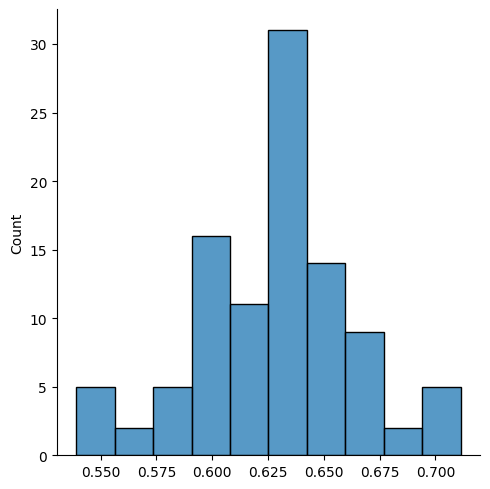

In [206]:
sns.displot(pyro.distributions.Dirichlet(torch.tensor([59., 99.])/1).sample((100,))[:,1].tolist())

In [154]:
torch.sum(fixed, dim=0)

tensor([0.0120, 0.0094, 0.0018, 0.0066, 0.0101, 0.0057, 0.0017, 0.0101, 0.0599,
        0.0179, 0.4055, 0.0220, 0.0074, 0.0069, 0.0091, 0.0062, 0.0462, 0.0134,
        0.0382, 0.0383, 0.0039, 0.0026, 0.0079, 0.0048, 0.0074, 0.0061, 0.0035,
        0.0065, 0.0070, 0.0091, 0.0025, 0.0095, 0.0194, 0.0190, 0.2319, 0.0231,
        0.0035, 0.0052, 0.0050, 0.0043, 0.0133, 0.0104, 0.0208, 0.0149, 0.0026,
        0.0046, 0.0061, 0.0073, 0.0102, 0.0076, 0.0023, 0.0068, 0.0047, 0.0051,
        0.0015, 0.0067, 0.0194, 0.0216, 0.2508, 0.0186, 0.0037, 0.0029, 0.0041,
        0.0032, 0.0141, 0.0079, 0.0150, 0.0137, 0.0025, 0.0017, 0.0053, 0.0023,
        0.0079, 0.0092, 0.0023, 0.0127, 0.0078, 0.0076, 0.0017, 0.0125, 0.0203,
        0.0230, 0.1362, 0.0210, 0.0063, 0.0041, 0.0048, 0.0087, 0.0180, 0.0097,
        0.0127, 0.0185, 0.0052, 0.0066, 0.0069, 0.0135], dtype=torch.float64)

In [151]:
fixed = torch.tensor(obj_sbs.beta_fixed.values)
beta_w = torch.tensor(obj_sbs.params["beta_w"].values)
denovo = torch.tensor(obj_sbs.params["beta_d"].values)
cum_weights = torch.ones((obj_sbs.k_denovo, obj_sbs.k_fixed))/obj_sbs.k_fixed

fixed_cum = obj_sbs._get_unique_beta_stick_breaking(beta_fixed=fixed, beta_denovo=None, beta_weights=cum_weights)
fixed_cum = obj_sbs._norm_and_clamp(fixed_cum)

print(torch.sum((fixed_cum * (torch.abs(fixed_cum - denovo)))) * torch.tensor(obj_sbs.x.values).sum())
print(torch.sum((fixed_cum * (torch.abs(fixed_cum - denovo)))) * obj_sbs.x.shape[0] * obj_sbs.x.shape[1])


tensor(93229.3786, dtype=torch.float64)
tensor(3165.8104, dtype=torch.float64)


In [144]:
obj_sbs.losses

[548331.2661516825,
 547488.5308755352,
 546821.1517237026,
 546292.3403537681,
 545873.1326154,
 545540.6874320571,
 545276.968117238,
 545067.7160041195,
 544901.6488833965,
 544769.8331482353]

In [127]:
len(obj_sbs.train_params)

1

In [102]:
pyro.distributions.Dirichlet(fixed_cum*1000).log_prob(denovo) 

tensor([-1197.6662, -2173.9854], dtype=torch.float64)

In [71]:
obj_sbs.gradient_norms.keys()

dict_keys(['beta_weights', 'kappa', 'beta_denovo', 'alpha'])

In [72]:
## self.x.sum() * torch.sum(beta_fixed_cum * (1 - torch.abs(beta_fixed_cum - beta_denovo)))
obj_sbs.params["beta_w"] 

,SBS1,SBS5,DN
D1,0.010390,0.053112,0.936498
D2,0.012151,0.031028,0.956821


In [69]:
## self.x.sum() * torch.sum(beta_fixed_cum * (torch.abs(beta_fixed_cum - beta_denovo)))
obj_sbs.params["beta_w"] 

,SBS1,SBS5,DN
D1,0.190525,0.001543,0.807932
D2,0.310543,0.002051,0.687406


In [94]:
## self.x.sum() * torch.sum(beta_fixed_cum * (torch.abs(beta_fixed_cum - beta_denovo)))
obj_sbs.params["beta_w"] 

,SBS1,SBS5,DN
D1,0.164594,0.012627,0.822779
D2,0.290413,0.007297,0.702290


In [105]:
## self.n_samples * self.contexts * pyro.distributions.Dirichlet(beta_fixed_cum*1000).to_event(1).log_prob(beta_denovo))
obj_sbs.params["beta_w"] 

,SBS1,SBS5,DN
D1,0.003888,0.302277,0.693835
D2,0.017563,0.138528,0.843909


In [101]:
pyro.param("beta_weights")

tensor([[0.2734, 0.3623, 0.3643],
        [0.3783, 0.2133, 0.4084]], dtype=torch.float64, grad_fn=<DivBackward0>)

In [99]:
obj_sbs.params["beta_w"] 

tensor([[0.2734, 0.3623, 0.3643],
        [0.3783, 0.2133, 0.4084]], dtype=torch.float64)

In [100]:
obj_sbs.gradient_norms.keys() 

dict_keys(['beta_denovo', 'alpha'])

In [42]:
obj_sbs.params["alpha"].sum(axis=1)

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
145    1.0
146    1.0
147    1.0
148    1.0
149    1.0
Length: 150, dtype: float32

In [9]:
k_dn = 2
k_f = 3
n_samples = 5
beta_weights = pyro.distributions.Dirichlet(torch.ones(k_dn, k_f+1)).sample()
alpha_star = pyro.distributions.Dirichlet(torch.ones(n_samples, k_dn)).sample()
print("beta weights\n", beta_weights)
print("alpha star\n", alpha_star)

beta weights
 tensor([[0.5773, 0.1750, 0.0487, 0.1990],
        [0.0189, 0.2324, 0.1488, 0.5999]])
alpha star
 tensor([[0.4076, 0.5924],
        [0.0937, 0.9063],
        [0.3129, 0.6871],
        [0.5145, 0.4855],
        [0.9945, 0.0055]])


In [36]:
beta_weights[1,2]

tensor(0.1488)

In [13]:
alpha = torch.zeros((n_samples, k_dn+k_f))

for n in range(n_samples):
    for j in range(k_dn):
        for r in range(k_f):
            alpha[n, r] += torch.sum(alpha_star[n,j]) * beta_weights[j,r]
        
        for d in range(k_f, k_f+k_dn):
            alpha[n, d] += torch.sum(alpha_star[n,j]) * beta_weights[j,-1]

print(alpha)

tensor([[0.2465, 0.2090, 0.1080, 0.4365, 0.4365],
        [0.0712, 0.2271, 0.1394, 0.5624, 0.5624],
        [0.1936, 0.2145, 0.1174, 0.4745, 0.4745],
        [0.3062, 0.2029, 0.0973, 0.3937, 0.3937],
        [0.5742, 0.1753, 0.0492, 0.2012, 0.2012]])


In [ ]:
obj_sbs.params["beta_w"]

In [ ]:
obj_sbs.params["beta_d"]

In [ ]:
obj_dbs = run.fit(
    x=m_dbs, 
    k_list=3, 
    lr=0.005, 
    optim_gamma=0.1,
    n_steps=10, 
    # cluster=6, 
    dirichlet_prior=True,
    beta_fixed=cosmic_dbs.loc[["DBS4"]], 
    hyperparameters={"alpha_sigma":.15, "alpha_p_sigma":1., "alpha_p_conc0":0.6, 
                     "alpha_p_conc1":0.6, "alpha_rate":1., "pi_conc0":0.5, "alpha_conc":100,
                     "scale_factor_alpha":10000, "scale_factor_centroid":1000, "scale_tau":0},
    enforce_sparsity = True, 
    reg_weight=0., 
    store_parameters = True, 
    seed_list=[92],
    nonparametric=True,
    store_fits=True
    )


In [ ]:
alpha_sbs = obj_sbs.params["alpha"] 
alpha_dbs = obj_dbs.params["alpha"] 

In [ ]:
input = [alpha_sbs, alpha_dbs] 
input_tensor = [torch.tensor(alpha_sbs.values), torch.tensor(alpha_dbs.values)]
max_shape = max([i.shape[1] for i in input_tensor])
# stacked = torch.stack(input_tensor)

In [ ]:
mixture = run.fit(
    alpha=input, 
    lr=0.005, 
    optim_gamma=0.1,
    n_steps=3000,
    cluster=5, 
    hyperparameters={"alpha_sigma":.15, "alpha_p_sigma":1., "alpha_p_conc0":0.6, 
                     "alpha_p_conc1":0.6, "alpha_rate":1., "pi_conc0":0.5, "alpha_conc":100,
                     "scale_factor_alpha":10000, "scale_factor_centroid":1000, "scale_tau":0},
    store_parameters = True, 
    seed_list=[92],
    nonparametric=True,
    store_fits=True
    )


In [ ]:
import torch.nn.functional as F
def mix_weights(beta):
    '''
    Function used for the stick-breaking process.
    '''
    print("beta =", beta)
    beta1m_cumprod = (1 - beta).cumprod(-1)
    print("beta1m_cumprod =", beta1m_cumprod)
    res1 = F.pad(beta, (0, 1), value=1)
    res2 = F.pad(beta1m_cumprod, (1, 0), value=1)
    res = res1 * res2
    print(f"res1 = {res1}, res2 = {res2}, res = {res}\n")
    return res


In [ ]:
cluster = 6
with pyro.plate("beta_plate", cluster-1):
    pi_beta = pyro.sample(f"beta", pyro.distributions.Beta(1, 1.1755e-36))
    # pi_beta = torch.tensor([1.1755e-36, 2.1648e-18, 1.1755e-36, 6.6389e-33, 1.1755e-36])
    print("pi_beta =", pi_beta)
    pi = mix_weights(pi_beta)

print(pi)

In [ ]:
beta_star = torch.zeros(k_denovo, 96, dtype=torch.float64) 
for i in range(k_denovo):
    tmp_sbs = torch.cat((ref_sbs, dn_sbs[i].unsqueeze(0)))
    beta_star[i] = pi[i].unsqueeze(0).matmul(tmp_sbs) 

In [ ]:
pyro.distributions.Gamma(0.01, 0.01).sample((5,))

In [ ]:
pyro.distributions.Dirichlet(torch.ones(5)).sample()

In [ ]:
(1 - pyro.distributions.Beta(1, 1e-10).sample((cluster-1,))).cumprod(-1)

In [ ]:
pi = torch.zeros((10,))
pi[:5] = 5
pi 

In [ ]:
alpha_centr = mixture[0].params["alpha_prior"]
print(alpha_centr) 

In [ ]:
print(sklearn.metrics.normalized_mutual_info_score(mixture.groups, g_sbs)) 
print(sklearn.metrics.normalized_mutual_info_score(mixture.groups, g_dbs)) 

In [ ]:
print(obj_sbs.params["scale_factor_centroid"])
print(obj_sbs.params["scale_factor_alpha"]) 

In [ ]:
obj_sbs.params

In [ ]:
obj_sbs.train_params[6]["scale_factor_centroid"]

In [ ]:
obj_sbs.params["pi_conc0"] 

In [ ]:
sns.scatterplot(x=range(len(obj_sbs.likelihoods)), y=obj_sbs.likelihoods) 

In [ ]:
sns.scatterplot(x=range(len(obj_sbs.losses)), y=obj_sbs.losses) 

In [ ]:
try: sns.scatterplot(x=range(len(obj_sbs.gradient_norms["scale_factor_centroid_param"])), 
                     y=obj_sbs.gradient_norms["scale_factor_centroid_param"]) 
except: print() 

In [ ]:
try: sns.scatterplot(x=range(len(obj_sbs.gradient_norms["scale_factor_alpha_param"])), 
                     y=obj_sbs.gradient_norms["scale_factor_alpha_param"]) 
except: print() 

In [ ]:
try: sns.scatterplot(x=range(len(obj_sbs.gradient_norms["alpha_prior_param"])), y=obj_sbs.gradient_norms["alpha_prior_param"]) 
except: print() 

In [ ]:
try: sns.scatterplot(x=range(len(obj_sbs.gradient_norms["alpha_prior_param"])), y=obj_sbs.gradient_norms["alpha_prior_param"]) 
except: print() 

In [ ]:
try: sns.scatterplot(x=range(len(obj_sbs.gradient_norms["pi_param"])), y=obj_sbs.gradient_norms["pi_param"]) 
except: print() 

In [ ]:
try: sns.scatterplot(x=range(len(obj_sbs.gradient_norms["pi_conc0_param"])), y=obj_sbs.gradient_norms["pi_conc0_param"]) 
except: print() 

In [ ]:
try: sns.scatterplot(x=range(len(obj_sbs.gradient_norms["alpha"])), y=obj_sbs.gradient_norms["alpha"]) 
except: print() 

In [ ]:
try: sns.scatterplot(x=range(len(obj_sbs.gradient_norms["beta_denovo"])), y=obj_sbs.gradient_norms["beta_denovo"])
except: print()

In [ ]:
pd.DataFrame(np.array(obj_sbs.init_params["alpha_prior_param"]), columns=obj_sbs.params["alpha"].columns).plot.bar(stacked=True, legend=False) 

In [ ]:
try: pd.DataFrame(np.array(obj_sbs.params["alpha_prior"]), columns=obj_sbs.params["alpha_prior"].columns).plot.bar(stacked=True, legend=False) 
except Exception as e: print() 

In [ ]:
try:
    for gid in set(np.array(obj_sbs.groups)):
        tmp = [i for i, v in enumerate(obj_sbs.groups) if v == gid]
        # tmp = [i for i, v in enumerate(obj_sbs.groups) if (v == gid and i in idxs)]
        if len(tmp) == 0: continue
        pd.DataFrame(np.array(obj_sbs.params["alpha"]), columns=obj_sbs.params["alpha"].columns, 
                     index=obj_sbs.params["alpha"].index).iloc[tmp].plot.bar(stacked=True)
except Exception as e:
    print(e)
    obj_sbs.alpha.plot.bar(stacked=True, legend=False) 


In [ ]:
try:
    for sbs in pd.concat((obj_sbs.params["beta_f"], obj_sbs.params["beta_d"])).index:
        pd.concat((obj_sbs.params["beta_f"], obj_sbs.params["beta_d"])).loc[[sbs]].transpose().plot.bar()
except Exception as e:
    print(e)